# Code for Fig. SM4

In [35]:
%load_ext autoreload
%autoreload 1
%aimport general_functions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from joblib import Parallel, delayed

from general_functions import (compute_energies, purcell_factor, complete_dynamics, g0_fun)

This notebook is simular to the Fig3 one, but now the lattice has an out-of-plane polarization.

## Top of a dipole (a, c, d)

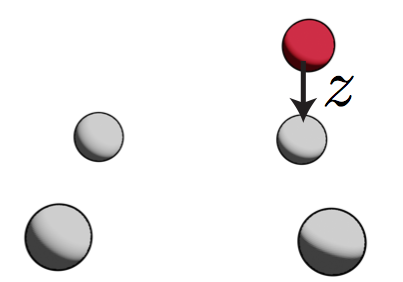

### Analytical

In [37]:
pol_lat = np.array([[0, 0, 1]]).T
pol_emi = np.array([[0, 1, 0]]).T

d = 1
lambda0 = d / 0.28
k0 = 2 * np.pi / lambda0
aho = 0.1 * d

n = 2 ** 10 + 1
nmax = 9

b1 = 2 * np.pi / d * np.array([1, 0])
b2 = 2 * np.pi / d * np.array([0, 1])
A = d ** 2

G0 = g0_fun(k0, aho)

k_x = np.linspace(-np.pi, np.pi, n) / d
k_X, k_Y = np.meshgrid(k_x, k_x)

k = np.vstack((k_X.flatten(), k_Y.flatten())).T

x = np.arange(0, n) - n / 2 + d / 2
y = np.arange(0, n) - n / 2 + d / 2
x, y = np.meshgrid(x, y)
z = np.zeros((n, n))
r_lat = [x, y, z]

In [38]:
J, Gamma = compute_energies(b1, b2, A, nmax, k0, aho, k, G0=G0, polarizations=[pol_lat])
omega_k = (J - 0.5j * Gamma).reshape(n, n)

omega_q = np.real(omega_k).reshape(n, n)[n // 2, -1]

In [39]:
n_pos = 100  # Number of points

x_vector = np.ones(n_pos) * d * 0
y_vector = np.ones(n_pos) * d * 0
z_vector = np.linspace(0.1, 2, n_pos) * d

r_emi_vector = np.array([x_vector, y_vector, z_vector])

In [40]:
pbar = tqdm(range(n_pos), desc='Computing Purcell')
results = Parallel(n_jobs=6, backend='multiprocessing')(
    delayed(purcell_factor)(r_lat, r_emi_vector[:, j], [k_X, k_Y],
                            omega_k, omega_q, k0, pol_lat, pol_emi) for j in pbar)

results = np.array(results)
optical_depth = results[:, 1] / results[:, 0]

Computing Purcell:   0%|          | 0/100 [00:00<?, ?it/s]

### Numerical

In [30]:
border = 15
max_gamma = 15

N_x = 61
N_y = N_x
x_pos = np.arange(0, N_x) - N_x / 2 + d / 2
y_pos = np.arange(0, N_y) - N_y / 2 + d / 2
x_pos, y_pos = np.meshgrid(x_pos, y_pos)
x_pos = x_pos.flatten()
y_pos = y_pos.flatten()
z_pos = np.zeros(len(x_pos))
r_pos = [x_pos, y_pos, z_pos]

gamma_emi = 0.002
omega_emi = -0.256  # For d / lambda_0 = 0.28
# omega_emi = -0.27  # For d / lambda_0 = 0.19

dt = 2e-3 / gamma_emi
tf = dt * 2 ** 10

psi0 = np.zeros(len(x_pos) + 1)
psi0[-1] = 1

In [31]:
purcell_numerical = np.zeros(n_pos)
population_lattice = [None] * n_pos
population_emitter = [None] * n_pos
n_M = np.zeros(n_pos)

x_vector = np.zeros(n_pos)
y_vector = np.zeros(n_pos)
r_emi_vector = np.array([x_vector, y_vector, z_vector])

pbar = tqdm(total=n_pos, desc='Computing dynamics')
for i in range(n_pos):
    emitter = [r_emi_vector[:, i]]
    
    results = complete_dynamics(r_pos, k0, pol_lat, dt, tf, psi0, N_x, N_y, emitter, [pol_emi], gamma_emi,
                      omega_emi, border, max_gamma=max_gamma, theta_max=np.pi / 4)
    
    purcell_numerical[i] = results['Q_n'][-1]
    
    population = np.abs(results['psi']) ** 2
    population_lattice[i] = np.sum(population[:, :-1], axis=-1)
    population_emitter[i] = np.sum(population[:, -1:], axis=-1)    
    
    n_M[i] = results['n_M']
    pbar.update()    
pbar.close()

Computing dynamics:   0%|          | 0/100 [00:00<?, ?it/s]

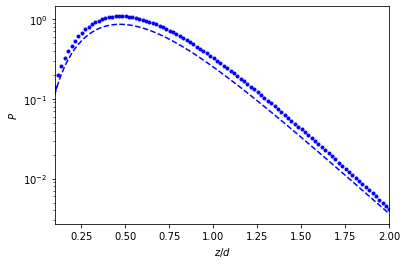

In [41]:
fig, ax = plt.subplots()
ax.plot(z_vector, optical_depth, 'b--', label='semi-analytically')
ax.plot(z_vector, purcell_numerical, 'b.', label='numerical')
ax.set_yscale('log')
ax.set_xlim(min(z_vector), max(z_vector))
ax.set_xlabel(r'$z/d$')
ax.set_ylabel(r'$P$');

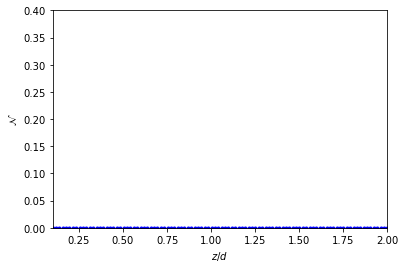

In [33]:
fig, ax = plt.subplots()
ax.plot(z_vector, n_M, 'b.')
ax.set_xlim(min(z_vector), max(z_vector))
ax.set_ylim(0, 0.4)
ax.set_xlabel(r'$z/d$')
ax.set_ylabel(r'$\mathcal{N}$');

The value of z / d = 0.407


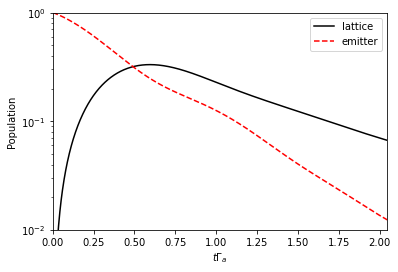

In [34]:
z_target = 0.4
index = np.argmin(np.abs(z_target - z_vector))
print('The value of z / d = {:.3f}'.format(z_vector[index]))

fig, ax = plt.subplots()
ax.plot(results['time'] * gamma_emi, population_lattice[index], 'k', label='lattice')
ax.plot(results['time'] * gamma_emi, population_emitter[index], 'r--', label='emitter')
ax.legend()
ax.set_ylabel('Population')
ax.set_xlabel(r'$t\Gamma_a$')

ax.set_yscale('log')
ax.set_ylim(0.01, 1)
ax.set_xlim(0, tf * gamma_emi);

## Plaquete (b, e, f)

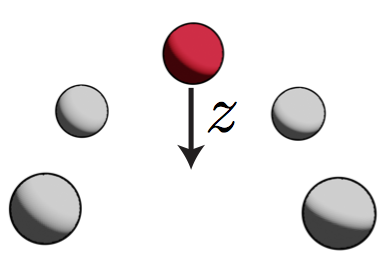

### Analytical

In [18]:
n_pos = 100  # Number of points

x_vector = np.ones(n_pos) * d * 0.5
y_vector = np.ones(n_pos) * d * 0.5
z_vector = np.linspace(0.1, 2, n_pos) * d

r_emi_vector = np.array([x_vector, y_vector, z_vector])

In [19]:
pbar = tqdm(range(n_pos), desc='Computing Purcell')
results = Parallel(n_jobs=-1, backend='multiprocessing')(
    delayed(purcell_factor)(r_lat, r_emi_vector[:, j], [k_X, k_Y],
                            omega_k, omega_q, k0, pol_lat, pol_emi) for j in pbar)

results = np.array(results)
optical_depth = results[:, 1] / results[:, 0]

Computing Purcell:   0%|          | 0/100 [00:00<?, ?it/s]

### Numerical

In [20]:
purcell_numerical = np.zeros(n_pos)
population_lattice = [None] * n_pos
population_emitter = [None] * n_pos
n_M = np.zeros(n_pos)

x_vector = np.ones(n_pos) * 0.5 * d
y_vector = np.ones(n_pos) * 0.5 * d
r_emi_vector = np.array([x_vector, y_vector, z_vector])

pbar = tqdm(total=n_pos, desc='Computing dynamics')
for i in range(n_pos):
    emitter = [r_emi_vector[:, i]]
    
    results = complete_dynamics(r_pos, k0, pol_lat, dt, tf, psi0, N_x, N_y, emitter, [pol_emi], gamma_emi,
                      omega_emi, border, max_gamma=max_gamma, theta_max=np.pi / 4)
    
    purcell_numerical[i] = results['Q_n'][-1]
    
    population = np.abs(results['psi']) ** 2
    population_lattice[i] = np.sum(population[:, :-1], axis=-1)
    population_emitter[i] = np.sum(population[:, -1:], axis=-1)    
    
    n_M[i] = results['n_M']
    pbar.update()    
pbar.close()

Computing dynamics:   0%|          | 0/100 [00:00<?, ?it/s]

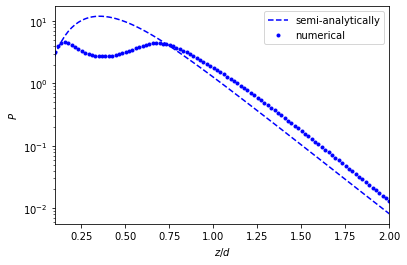

In [27]:
fig, ax = plt.subplots()
ax.plot(z_vector, optical_depth, 'b--', label='semi-analytically')
ax.plot(z_vector, purcell_numerical, 'b.', label='numerical')
ax.legend()
ax.set_yscale('log')
ax.set_xlim(min(z_vector), max(z_vector))
ax.set_xlabel(r'$z/d$')
ax.set_ylabel(r'$P$');

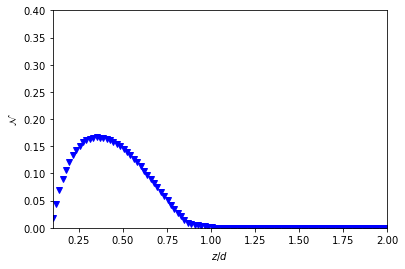

In [25]:
fig, ax = plt.subplots()
ax.plot(z_vector, n_M, 'bv')
ax.set_xlim(min(z_vector), max(z_vector))
ax.set_ylim(0, 0.4)
ax.set_xlabel(r'$z/d$')
ax.set_ylabel(r'$\mathcal{N}$');

The value of z / d = 0.407


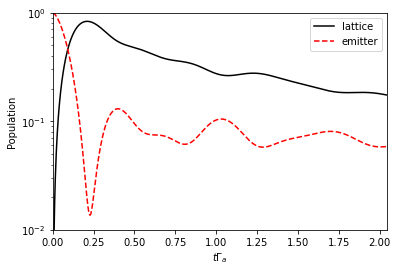

In [26]:
z_target = 0.4
index = np.argmin(np.abs(z_target - z_vector))
print('The value of z / d = {:.3f}'.format(z_vector[index]))

fig, ax = plt.subplots()
ax.plot(results['time'] * gamma_emi, population_lattice[index], 'k', label='lattice')
ax.plot(results['time'] * gamma_emi, population_emitter[index], 'r--', label='emitter')
ax.legend()
ax.set_ylabel('Population')
ax.set_xlabel(r'$t\Gamma_a$')

ax.set_yscale('log')
ax.set_ylim(0.01, 1)
ax.set_xlim(0, tf * gamma_emi);